# Get relevant libraries

In [1]:
import ujson as json

%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import os
import numpy as np
from pandas.compat import StringIO
from pandas.io.common import urlopen
from IPython.display import display, display_pretty, Javascript, HTML
from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts
import matplotlib.pyplot as plt

# Create charts from dataframe

In [21]:
filename = "/Users/fnokeke/dev/student-streams/dataset/LocationHistory.json"
with open(filename) as json_file:
    raw = json.load(json_file)

ld = pd.DataFrame(raw['locations'])
print("Number of items in data: %d") % len(ld)

# free up memory
del raw

Number of items in data: 266972


# Convert to typical units and rename columns

In [22]:
df = ld.copy()
df['latitudeE7'] = df['latitudeE7']/float(1e7)
df['longitudeE7'] = df['longitudeE7']/float(1e7)
df['timestampMs'] = df['timestampMs'].map(lambda x: float(x))
df['timestamp2'] = df['timestampMs'].map(lambda x: float(x)/1000)
df['datetime'] = df.timestamp2.map(datetime.datetime.fromtimestamp)

df.rename(columns={
'latitudeE7': 'latitude',
'longitudeE7': 'longitude',
'timestampMs': 'timestamp'
}, inplace=True)

df = df[['latitude', 'longitude', 'accuracy', 'datetime']]
df.head()

,latitude,longitude,accuracy,datetime
0,42.445009,-76.481233,20,2015-10-09 18:40:49.815
1,42.445002,-76.481257,20,2015-10-09 18:39:49.791
2,42.445001,-76.481254,53,2015-10-09 18:38:48.981
3,42.444977,-76.481236,51,2015-10-09 18:37:48.476
4,42.444994,-76.481249,37,2015-10-09 18:36:59.451


# Ignore locations with accuracy estimates over 1000m

In [23]:
old_len = len(df)
df = df[df.accuracy <= 1000]
df = df.sort_values('datetime', ascending=True)
print("No of rows dropped: %d") % (old_len - len(df))

No of rows dropped: 14677


# Specify only places of interest in Ithaca and ignore locations outside Ithaca

In [26]:
HOME = (42.446594, -76.493736)
WORK = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0
old_len = len(df)

# home location is used to estimate places outside Ithaca but 
# work location works just as well because the lat and lon margins 
# are definitely outside Ithaca
df = df[abs(df.latitude - HOME[0]) < lat_margin]
df = df[abs(df.longitude - WORK[1]) < lon_margin]

print("No of rows dropped: %d") % (old_len - len(df))

No of rows dropped: 0


# Get only a specific number of weeks of data from specific start date

In [34]:
df_wk = df.copy()

no_of_weeks = 10
start_date = "2014-11-09"

start_date = pd.to_datetime(start_date)
selected_dates = []
no_of_days = no_of_weeks * 7

# create dates based on total number of weeks
for i in range(no_of_days):
    x = start_date + datetime.timedelta(days=i)
    x = x.strftime('%Y-%m-%d')
    selected_dates.append(x)
    
df_wk['date'] = df_wk.datetime.map(lambda x: x.strftime("%Y-%m-%d"))
df_wk = df_wk[df_wk.date.isin(selected_dates)]
df_wk = df_wk[['latitude', 'longitude', 'datetime', 'date']]
print "%d week(s) of data: %d rows." % (no_of_weeks, len(df_wk))
print "No of unique dates: %d." % len(set(selected_dates))

10 week(s) of data: 35252 rows.
No of unique dates: 70.


# Extract lat,lon for clustering

In [36]:
coordinates = df_wk.as_matrix(columns=['latitude', 'longitude'])
coordinates

array([[ 42.4467531, -76.4934493],
       [ 42.4467796, -76.49335  ],
       [ 42.4467713, -76.4933573],
       ..., 
       [ 42.4333735, -76.4711208],
       [ 42.4332949, -76.4711238],
       [ 42.4332932, -76.4711206]])

# KMeans cluster of location 

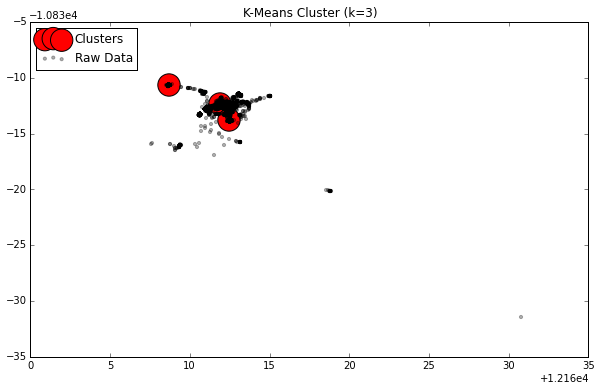

k = 3
N = 35252
cluster_centroids = 3
closest_centroids = 35252
unique_closest_centroids = 3


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import DBSCAN
%matplotlib inline

N = len(coordinates)
k = 3
i = 50
w = whiten(coordinates) # normalize

cluster_centroids, closest_centroids = kmeans2(w, k, iter=i, minit='points')
plt.figure(figsize=(10, 6), dpi=100)
cluster_plot = plt.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', s=500)
orig_plot = plt.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
plt.title("K-Means Cluster (k=%d)" % k)
plt.legend((cluster_plot, orig_plot), ('Clusters', 'Raw Data'), loc='upper left')
plt.show()

# Sanity Check
print 'k =', k
print 'N =', N
print 'cluster_centroids =', len(cluster_centroids)
print 'closest_centroids =', len(closest_centroids)
print 'unique_closest_centroids =', len(np.unique(closest_centroids))

# DBSCAN cluster of location

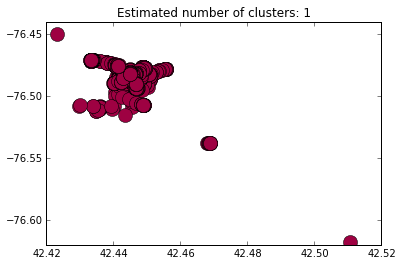

In [38]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# Compute DBSCAN
X = coordinates
db = DBSCAN(eps=0.3, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

##############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Specify only places of interest in Ithaca and ignore locations outside Ithaca

In [ ]:
HOME = (42.446594, -76.493736)
WORK = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0

# home location is used to estimate places outside Ithaca but 
# work location works just as well because the lat and lon margins 
# are definitely outside Ithaca
ld_wk = ld_wk[abs(ld_wk.latitude - HOME[0]) < lat_margin]
ld_wk = ld_wk[abs(ld_wk.longitude - WORK[1]) < lon_margin]

print "No of rows: %d." % len(ld_wk)
print "No of unique dates: %d." % len(set(ld_wk.date))

# Label every location as either home, work or other

In [ ]:
lat_error_margin = 0.0005
lon_error_margin = 0.005

POINTS = {
    'home': HOME,
    'work': WORK
}

def get_loc_label(df, points):
    for label, point in points.items():
        within_lat = abs(df['latitude'] - point[0]) <= lat_error_margin
        within_lon = abs(df['longitude'] - point[1]) <= lon_error_margin
        if (within_lat and within_lon):
            return label
    else:
        return 'other'

ld_wk['loc_label'] = ld_wk.apply(lambda x: get_loc_label(x, POINTS), axis='columns')
ld_wk.head()

In [ ]:
oo = ld_wk[(ld_wk.date=="2014-09-02")]# &
           #(ld_wk.loc_label=="work")]

import pprint as pp
for x in oo.values:
    pp.pprint(x)

# Mark every day by numeric value (0=Mon, 6=Sun)

In [ ]:
weekday_patterns = ld_wk[['datetime', 'loc_label']]
weekday_patterns['day'] = weekday_patterns.datetime.map(lambda x: x.weekday())
weekday_patterns.head()

# Day of week by location frequency

In [ ]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")

ggplot(weekday_patterns, aes("day", fill='loc_label')) + geom_bar() + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_bw()

# Trend for day of week by location frequency

In [ ]:
wkdf = weekday_patterns[['day', 'loc_label']]
wkdf['freq'] = 0
wkdf = wkdf.groupby(['day', 'loc_label']).count().reset_index()

ggplot(wkdf, aes('day', 'freq', color='loc_label')) + geom_line(size=5) + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_seaborn()

# Show location frequency by date (ggplot)

In [ ]:
date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['freq'] = 0

date_df = date_df.set_index('datetime')
date_df = date_df.groupby('loc_label').resample('D', how='count').reset_index()

ggplot(date_df, aes('datetime', 'freq', color='loc_label')) + \
    geom_line(size=5) + \
    scale_x_date(name="Date", labels="%b %d", breaks=date_breaks("1 week")) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x  = element_text(angle = 90, hjust = 1))

# Day of week by time of day for each location

In [ ]:
day_patterns = ld_wk[['datetime', 'loc_label']]
day_patterns['day'] = day_patterns.datetime.map(lambda x: x.weekday())
day_patterns['time'] = day_patterns.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

ggplot(day_patterns, aes('day', 'time', color='loc_label')) + \
    geom_point() + \
    scale_x_continuous(name = "Day of Week", breaks=range(0,8), labels=weekday_label) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    theme_bw()

# Different dates by time and proportion of each location

In [ ]:
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['time'] = date_df.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

ggplot(date_df, aes('datetime', 'time', color='loc_label')) + \
    geom_point(size=3) + \
    scale_x_date(name="Date", labels="%a %b %d", breaks=date_breaks("3 days")) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x=element_text(angle = 90, hjust = 1))

# Time left and returned from specified location

In [ ]:
ld_wk.head()

In [ ]:
def left_loc(dataframe, date, loc_label):
    if date not in dataframe.date.tolist():
        return -1
    
    all_labels = ['home', 'work', 'other']
    all_labels.remove(loc_label)
    
    df = dataframe[(dataframe.date == date)]
    locations = df.loc_label.tolist()
    
    OUT_OF_RANGE = 999999
    label_1, label_2 = all_labels[0], all_labels[1]
    index_1 = locations.index(label_1) if label_1 in locations else OUT_OF_RANGE
    index_2 = locations.index(label_2) if label_2 in locations else OUT_OF_RANGE
    first_index = min(index_1, index_2)
    
    print "index_1: %d.\nindex_2: %d." % (index_1, index_2)

    time = -99
    if first_index != OUT_OF_RANGE:
        date = df.datetime.tolist()[first_index]
        # time = int(date.strftime("%H")) + float(date.strftime("%M"))/60
        time = date
    return time

In [ ]:
def returned_to_loc(dataframe, date, loc_label):
    if date not in dataframe.date.tolist():
        return -1
    
    all_labels = ['home', 'work', 'other']
    all_labels.remove(loc_label)
    
    df = dataframe[(dataframe.date == date)]
    reversed_locations = df.sort_values('datetime', ascending=False).to_list()
    locations = reversed_locations
    
    OUT_OF_RANGE = 999999
    loc_len = len(locations)
    
    label_1, label_2 = all_labels[0], all_labels[1] #TODO: remove
    
    index_1 = loc_len - 1 - locations.index(label_1) if label_1 in locations else OUT_OF_RANGE
    index_2 = loc_len - 1 - locations.index(label_2) if label_2 in locations else OUT_OF_RANGE
    first_index = min(index_1, index_2)

    time = -99
    if first_index != OUT_OF_RANGE:
        date = df.datetime.tolist()[first_index]
        time = int(date.strftime("%H")) + float(date.strftime("%M"))/60
        
        print "ret_index:", first_index

    return time

# Testing functions

In [ ]:
dates = ["2014-09-01", "2014-09-02", "2014-09-03"]
dd = ld_wk[ld_wk.date=="2014-09-01"]
dd.head()

In [ ]:
rr = [left_loc(ld_wk, d, "home") for d in dates]
rr

# Use plotly for heatmaps of day by time

In [ ]:
 tls.set_credentials_file(username='fnokeke', api_key='v44dzxrwuw')

In [ ]:
selected_patterns = day_patterns[day_patterns.loc_label=='other']
df = selected_patterns[['day', 'time']]
df.time = df.time.map(lambda x: int(x))
df['freq'] = 0

dfg = df.groupby(['time', 'day']).count().unstack()
dfg.columns = dfg.columns.droplevel()
dfg = dfg.reset_index(drop=True)

dfg.columns = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
hours = range(24)
new_index = []
for h in hours: 
    if h == 0:
        new_index.append('Midnight')
    elif h < 12:
        new_index.append(str(h) + 'am')
    elif h == 12:
        new_index.append('Noon')
    else:
        value = h % 12
        new_index.append(str(value) + 'pm')    
        
dfg.index = new_index
dfg = dfg.T
dfg

In [ ]:
dfg.iplot(kind='heatmap',colorscale='spectral',
                        filename='cufflinks/simple-heatmap')